In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from SALib.analyze import sobol
import warnings
from ema_workbench.analysis import feature_scoring
from ema_workbench.em_framework.salib_samplers import get_SALib_problem
from ema_workbench import (
    Model,
    Policy,
    ema_logging,
    SequentialEvaluator,
    MultiprocessingEvaluator,
    perform_experiments,
    Samplers,
    SequentialEvaluator,
)
# from dike_model_function import DikeNetwork 
from problem_formulation import get_model_for_problem_formulation, sum_over, sum_over_time
from ema_workbench.analysis import prim
from ema_workbench.em_framework.parameters import Constant

warnings.filterwarnings("ignore")

In [2]:
import numpy as np


In [3]:
dike_model_1, planning_steps = get_model_for_problem_formulation(6)

zero_policy = {"DaysToThreat": 0}
zero_policy.update({f"DikeIncrease {n}": 0 for n in planning_steps})
zero_policy.update({f"RfR {n}": 0 for n in planning_steps})

pol0 = {}
#
for key in dike_model_1.levers:
    s1, s2 = key.name.split("_")
    pol0.update({key.name: zero_policy[s2]})

policy0 = Policy("Policy 0", **pol0)

In [5]:
with MultiprocessingEvaluator(dike_model_1) as evaluator:
    results = evaluator.perform_experiments(scenarios=15000,policies=policy0,uncertainty_sampling=Samplers.LHS)

experiments, outcomes = results

100%|██████████████████████████████████████| 2000/2000 [04:08<00:00,  8.06it/s]


In [15]:
experiments

,A.0_ID flood wave shape,A.1_Bmax,A.1_Brate,A.1_pfail,A.2_Bmax,A.2_Brate,A.2_pfail,A.3_Bmax,A.3_Brate,A.3_pfail,...,A.3_DikeIncrease 2,A.4_DikeIncrease 0,A.4_DikeIncrease 1,A.4_DikeIncrease 2,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2,scenario,policy,model
0,49,113.754115,1.5,0.923469,104.131674,1.5,0.625901,253.883724,10.0,0.066721,...,0,0,0,0,0,0,0,0,Policy 0,dikesnet
1,32,303.981166,1.0,0.453709,160.573183,10.0,0.968489,145.116796,1.0,0.287868,...,0,0,0,0,0,0,0,1,Policy 0,dikesnet
2,92,258.288358,10.0,0.579144,38.291720,1.0,0.648049,344.343383,10.0,0.546021,...,0,0,0,0,0,0,0,2,Policy 0,dikesnet
3,124,90.874820,10.0,0.524218,324.410390,1.5,0.224546,170.244223,1.0,0.478301,...,0,0,0,0,0,0,0,3,Policy 0,dikesnet
4,27,330.512535,1.0,0.212248,260.752860,10.0,0.205663,53.821994,10.0,0.402658,...,0,0,0,0,0,0,0,4,Policy 0,dikesnet
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,118,165.080169,1.5,0.083854,204.417867,1.5,0.199151,259.524487,10.0,0.164752,...,0,0,0,0,0,0,0,1995,Policy 0,dikesnet
1996,125,194.963722,1.0,0.450201,217.637905,10.0,0.046837,56.809672,10.0,0.871883,...,0,0,0,0,0,0,0,1996,Policy 0,dikesnet
1997,117,172.412365,10.0,0.220253,268.693897,1.0,0.425870,330.960284,1.5,0.502089,...,0,0,0,0,0,0,0,1997,Policy 0,dikesnet
1998,38,153.370672,1.0,0.046779,171.949296,1.0,0.706486,164.081807,10.0,0.474570,...,0,0,0,0,0,0,0,1998,Policy 0,dikesnet


In [9]:
df =pd.DataFrame(outcomes)

In [10]:
# df["Expected Number of Deaths"] = df["A.1_Expected Number of Deaths"] + df["A.2_Expected Number of Deaths"] + df[
#      "A.3_Expected Number of Deaths"] + df["A.4_Expected Number of Deaths"] + df["A.5_Expected Number of Deaths"]
# df["Expected Annual Damage"] = df["A.1_Expected Annual Damage"] + df["A.2_Expected Annual Damage"] + df["A.3_Expected Annual Damage"] + df["A.4_Expected Annual Damage"] + df["A.5_Expected Annual Damage"]
#
# outcomes["Expected Number of Deaths"] = df["Expected Number of Deaths"]
# outcomes["Expected Annual Damage"] = df["Expected Annual Damage"]

## Feature importance (not required but nice to know)

In [11]:

df_feature_importance_out = df[["Expected Annual Damage", "Expected Number of Deaths", "A.5_Expected Number of Deaths","A.5_Expected Annual Damage","Expected Evacuation Costs"]]


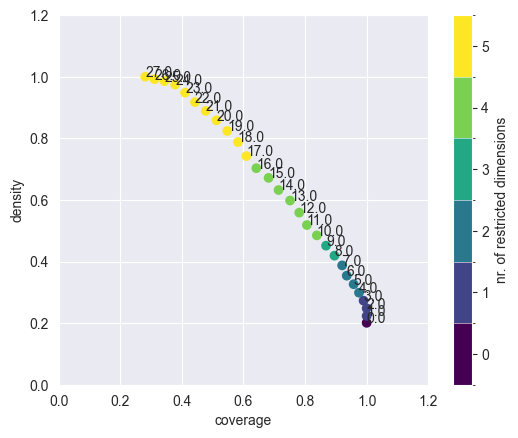

In [17]:
x = experiments

y = ((df_feature_importance_out["A.5_Expected Number of Deaths"] > list(np.sort(df_feature_importance_out["A.5_Expected Number of Deaths"]))[np.int64(0.80* len(df_feature_importance_out["A.5_Expected Number of Deaths"]))])
    |(df_feature_importance_out['A.5_Expected Annual Damage'] > list(np.sort(df_feature_importance_out['A.5_Expected Annual Damage']))[np.int64(0.80* len(df_feature_importance_out['A.5_Expected Annual Damage']))])
     )

prim_alg = prim.Prim(x, y, threshold=0.8,peel_alpha=0.1)
box1 = prim_alg.find_box()
box1.show_tradeoff(annotated=True)
plt.show()

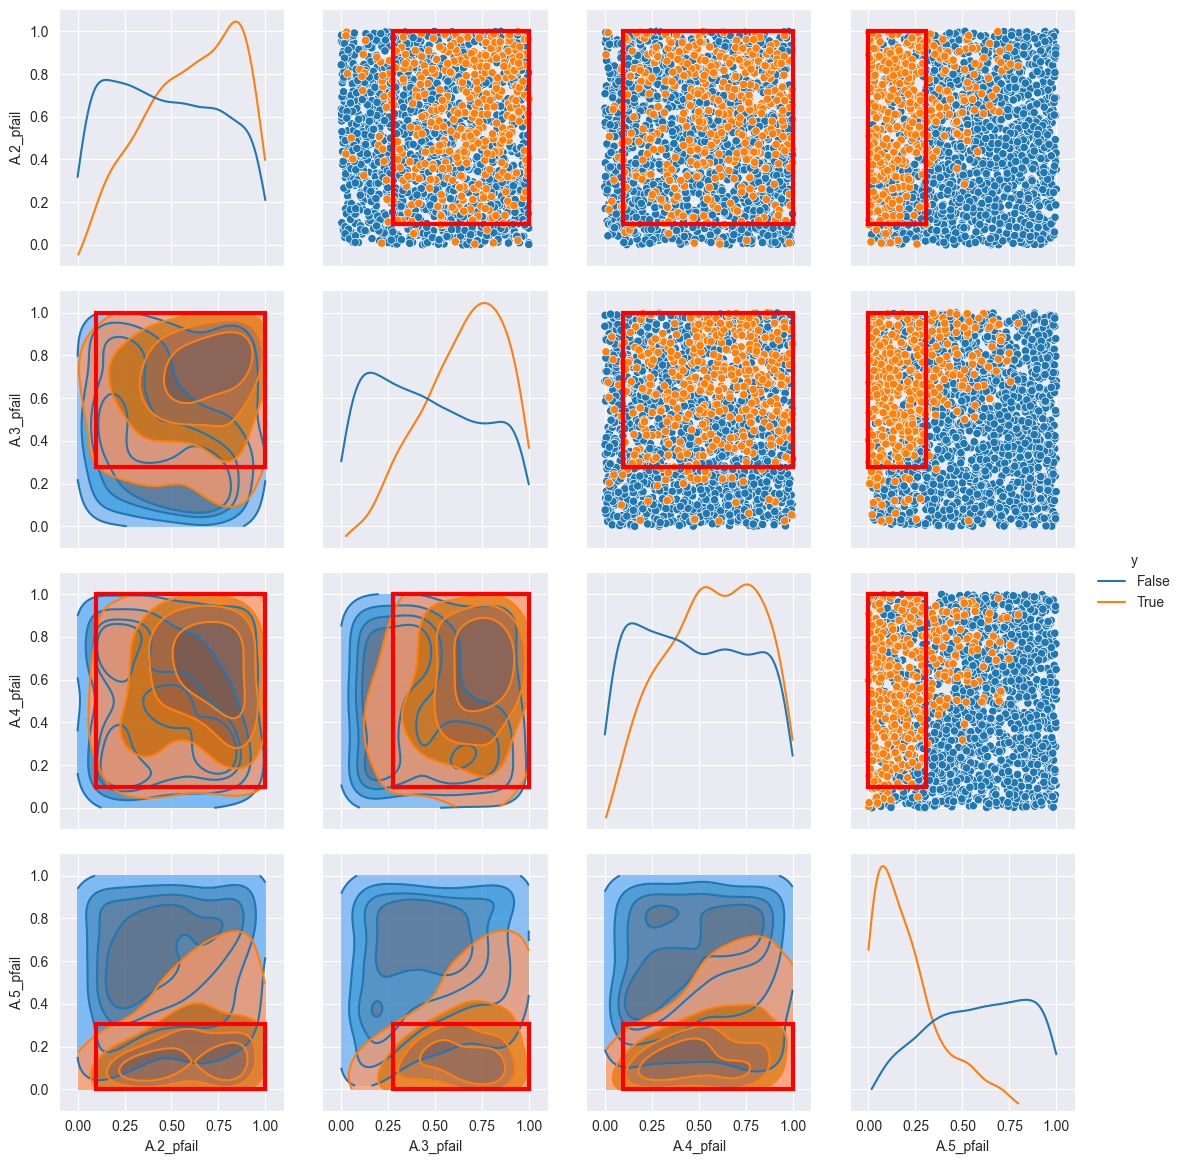

In [29]:
box1.select(16)
box1.show_pairs_scatter()
fig = plt.gcf()
fig.set_size_inches(12,12)
plt.show()

coverage      0.641791
density       0.702997
id           16.000000
k           258.000000
mass          0.183500
mean          0.702997
n           367.000000
res_dim       4.000000
Name: 16, dtype: float64

             box 16                                      
                min       max      qp value      qp value
A.5_pfail  0.000087  0.306834           NaN  5.355902e-57
A.3_pfail  0.277088  0.999942  1.677406e-07           NaN
A.2_pfail  0.099180  0.999588  3.670866e-02           NaN
A.4_pfail  0.097467  0.999730  5.544547e-02           NaN


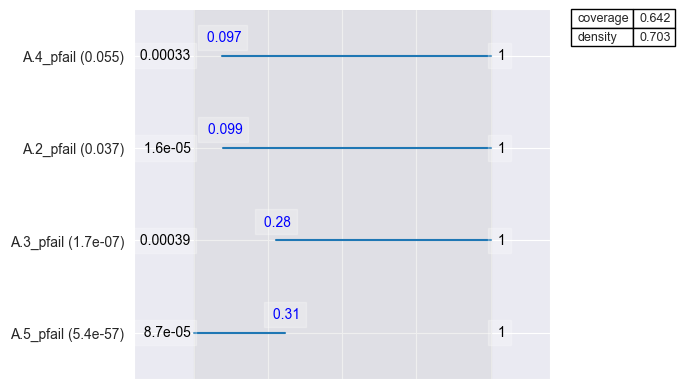

In [19]:
box1.inspect(16)
box1.inspect(16, style="graph")
plt.show()  

In [71]:
box1.inspect(16, style='data')[0][1]

box 16                                      
                min       max      qp value      qp value
A.5_pfail  0.000087  0.306834           NaN  5.355902e-57
A.3_pfail  0.277088  0.999942  1.677406e-07           NaN
A.2_pfail  0.099180  0.999588  3.670866e-02           NaN
A.4_pfail  0.097467  0.999730  5.544547e-02           NaN

In [51]:
pd.DataFrame(box1.inspect(16, style='data')[0][1]).to_csv('data\para_space_A5.csv')

### PRIM for general outcomes 

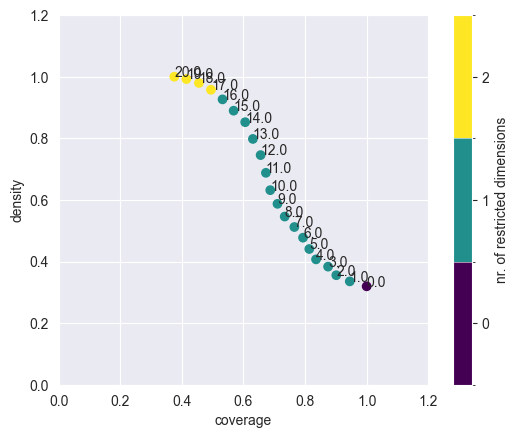

In [62]:
y = (
    (df_feature_importance_out['Expected Number of Deaths'] > list(np.sort(df_feature_importance_out["Expected Number of Deaths"]))[np.int64(0.8* len(df_feature_importance_out['Expected Number of Deaths']))])
     |(df_feature_importance_out['Expected Annual Damage'] > list(np.sort(df_feature_importance_out["Expected Annual Damage"]))[np.int64(0.8* len(df_feature_importance_out['Expected Annual Damage']))])
     )
# (df_feature_importance_out["Total Costs"] >= list(np.sort(df_feature_importance_out["Total Costs"]))[int(0.80* len(df_feature_importance_out["Total Costs"]))]) 
#      |
prim_alg = prim.Prim(x, y, threshold=0.95,peel_alpha=0.1)
box2 = prim_alg.find_box()
box2.show_tradeoff(annotated=True)
plt.show()

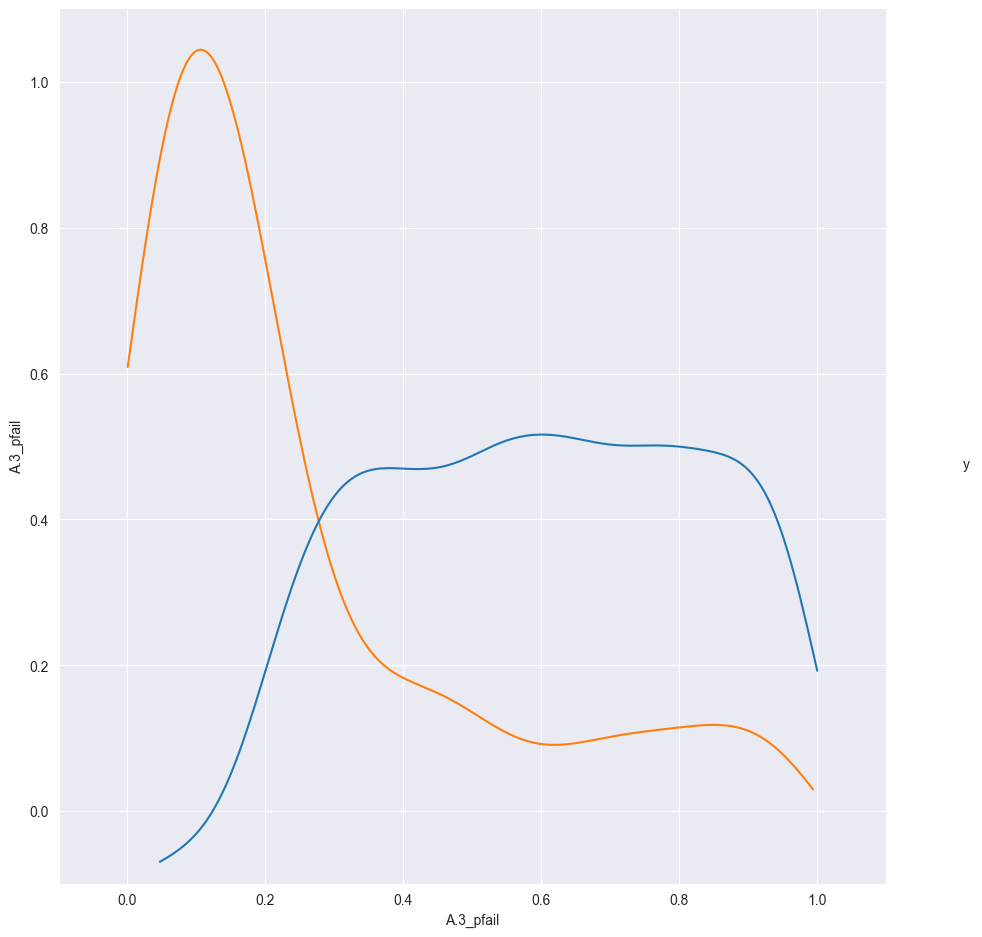

In [59]:
box2.select(12)
box2.show_pairs_scatter()
fig = plt.gcf()
fig.set_size_inches(12, 12)
plt.show()


coverage      0.655712
density       0.745552
id           12.000000
k           419.000000
mass          0.281000
mean          0.745552
n           562.000000
res_dim       1.000000
Name: 12, dtype: float64

             box 12                                 
                min       max qp value      qp value
A.3_pfail  0.000394  0.280975      NaN  3.639339e-95


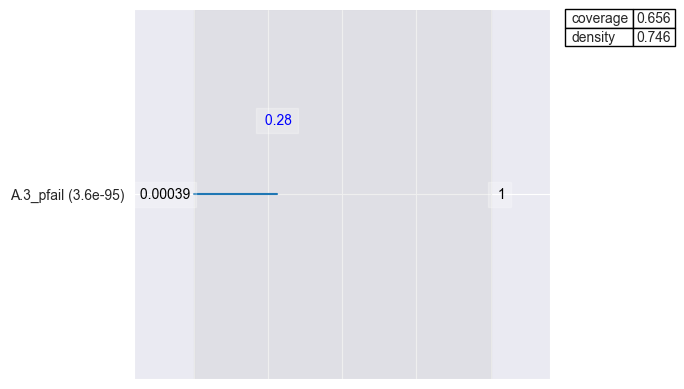

In [60]:
box2.inspect(12)
box2.inspect(12, style="graph")
plt.show()

In [47]:
a=box2.inspect(12)
type(box1)

coverage      0.781095
density       0.558719
id           12.000000
k           314.000000
mass          0.281000
mean          0.558719
n           562.000000
res_dim       4.000000
Name: 12, dtype: float64

             box 12                                  
                min       max  qp value      qp value
A.5_pfail  0.000087  0.429300       NaN  2.525162e-43
A.3_pfail  0.187960  0.999942  0.000006           NaN
A.2_pfail  0.099180  0.999588  0.025523           NaN
A.4_pfail  0.097467  0.999730  0.050331           NaN


ema_workbench.analysis.prim.PrimBox

In [68]:
box2.inspect(12, style='data')[0][0]

coverage      0.655712
density       0.745552
id           12.000000
k           419.000000
mass          0.281000
mean          0.745552
n           562.000000
res_dim       1.000000
Name: 12, dtype: float64

In [65]:
pd.DataFrame(box2.inspect(12, style='data')[0][1]).to_csv('data\para_space_all.csv')

In [1]:
from Convience_fun import create_scenario
import multirange as mr

df_param_space_A5 = (pd.read_csv('data/para_space_A5.csv').drop(0).rename(columns={"Unnamed: 0": "Variable"}))
df_param_space_all = (pd.read_csv('data/para_space_all.csv').drop(0).rename(columns={"Unnamed: 0": "Variable"}))

# pd.read_csv('data/para_space_all.csv').drop(0).rename(columns={"Unnamed: 0": "Variable"})

dike_model, planning_steps = get_model_for_problem_formulation(6)


def create_scenario_from_box(all, a5):
    para_list = []
    for uncertainty in dike_model.uncertainties:
        # print((variable in df_param_space_A5.Variable))
        variable = uncertainty.name
        # print(variable)
        if (variable in list(df_param_space_A5.Variable)) & (variable in list(df_param_space_all.Variable)) & (
                all + a5 == 2):
            min_1 = float(
                df_param_space_A5[df_param_space_A5['Variable'] == variable][df_param_space_A5.columns[1]].values[
                    0]) * 10000
            max_1 = float(
                df_param_space_A5[df_param_space_A5['Variable'] == variable][df_param_space_A5.columns[2]].values[
                    0]) * 10000

            min_2 = float(
                df_param_space_all[df_param_space_all['Variable'] == variable][df_param_space_all.columns[1]].values[
                    0]) * 10000
            max_2 = float(
                df_param_space_all[df_param_space_all['Variable'] == variable][df_param_space_all.columns[2]].values[
                    0]) * 10000

            boundaries = mr.overlap(range(int(min_1), int(max_1)), range(int(min_2), int(max_2)))
            para_list.append((boundaries.start + (boundaries.stop - boundaries.start) / 2) / 10000)
            print((boundaries.start + (boundaries.stop - boundaries.start) / 2) / 10000)
        elif (variable in list(df_param_space_A5.Variable)) & (a5 == True):
            min_1 = float(
                df_param_space_A5[df_param_space_A5['Variable'] == variable][df_param_space_A5.columns[1]].values[0])
            max_1 = float(
                df_param_space_A5[df_param_space_A5['Variable'] == variable][df_param_space_A5.columns[2]].values[0])

            para_list.append((min_1 + (max_1 - min_1) / 2))
        elif (variable in list(df_param_space_all.Variable)) & (all == True):
            min_2 = float(
                df_param_space_all[df_param_space_all['Variable'] == variable][df_param_space_all.columns[1]].values[0])
            max_2 = float(
                df_param_space_all[df_param_space_all['Variable'] == variable][df_param_space_all.columns[2]].values[0])

            para_list.append((min_2 + (max_2 - min_2) / 2))
        elif variable.startswith("d"):
            para_list.append(3.5)
        elif variable == "A.0_ID flood wave shape":
            para_list.append(17)
        elif variable.endswith("Brate"):
            para_list.append(1.5)
        else:
            para_list.append((uncertainty.lower_bound + (uncertainty.upper_bound - uncertainty.lower_bound) / 2))

    return create_scenario(para_list)


Scenarios_MOEA = [create_scenario_from_box(all=True, a5=True), create_scenario_from_box(all=True, a5=False),
                  create_scenario_from_box(all=False, a5=True)]
import pickle

with open("data\ScenariosOpenExplo", 'wb') as file:
    pickle.dump(Scenarios_MOEA, file) 



NameError: name 'pd' is not defined